# Import packages



In [20]:
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
import torch
# from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load training data

In [21]:
train_data = './Dataset/koi_table_2000.csv'
with open(train_data, newline='') as csvfile:
  df = pd.read_csv(train_data)
  dropped = ['loc_rowid','kepid', 'kepoi_name', 'koi_disposition']
  df = df.drop(columns=dropped)
  df = df.dropna()
  print(df.shape)

(1998, 15)


In [22]:
# training and validation set split
data = df.to_numpy()
train_X = data[:1518, :-1]
train_y = data[:1518, -1]

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size = 0.2, random_state=1)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(1214, 14) (1214,) (304, 14) (304,)


# Load testing data

In [23]:
test_data = "./Dataset/koi_test.csv"
with open(test_data, newline='') as csvfile:
  df = pd.read_csv(test_data)
  dropped = ['loc_rowid','kepid', 'kepoi_name', 'koi_disposition']
  df = df.drop(columns=dropped)
  df = df.dropna()
  data = df.to_numpy()
  test_X = data[:, :-1]
  test_y = data[:, -1]
  print(test_X.shape, test_y.shape)

(367, 14) (367,)


# Construct Model

In [24]:
# define model class
class Model(nn.Module):
    #define model architecture
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    # define model forward pass
    def forward(self, x):
        return self.linear_layer_stack(x)

# Training and Validation

In [25]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(1)

# load model
model = Model(input_features=train_X.shape[1], output_features=1, hidden_units=8)
model.to(device)
# declare loss fuction (BCE for binary classifier) and optimizer (Adam)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [26]:
# test if the model can forward input
model.eval()
with torch.inference_mode():
    X_test_tensor = torch.from_numpy(test_X).type(torch.FloatTensor).to(device)
    y_pred_logits = model(X_test_tensor.to(device))
y_pred_probs = torch.sigmoid(y_pred_logits)
y_preds = torch.round(y_pred_probs)
y_preds[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [27]:
# define function for accuracy and f1_score
from sklearn.metrics import accuracy_score, f1_score
def accuracy_fn(y_true, y_pred):
    y_true_np = y_true.cpu().detach().numpy()
    y_pred_np = y_pred.cpu().detach().numpy()
    return accuracy_score(y_true_np, y_pred_np)

def f1_score_fn(y_true, y_pred):
    y_true_np = y_true.cpu().detach().numpy()
    y_pred_np = y_pred.cpu().detach().numpy()
    return f1_score(y_true_np, y_pred_np)

In [28]:
# define function for precision, recall, confusion matrix
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def precisionm_fn(y_true, y_pred):
    y_true_np = y_true.cpu().detach().numpy()
    y_pred_np = y_pred.cpu().detach().numpy()
    return precision_score(y_true_np, y_pred_np)

def recall_fn(y_true, y_pred):
    y_true_np = y_true.cpu().detach().numpy()
    y_pred_np = y_pred.cpu().detach().numpy()
    return recall_score(y_true_np, y_pred_np)

def confusion_matrix_fn(y_true, y_pred):
    y_true_np = y_true.cpu().detach().numpy()
    y_pred_np = y_pred.cpu().detach().numpy()
    cm = confusion_matrix(y_true_np, y_pred_np)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    return

In [29]:
# Convert X_train, y_train, X_test, y_test to PyTorch tensors
X_train = torch.from_numpy(train_X).type(torch.FloatTensor).requires_grad_()
y_train = torch.from_numpy(train_y).type(torch.FloatTensor).requires_grad_()
X_val = torch.from_numpy(val_X).type(torch.FloatTensor)
y_val = torch.from_numpy(val_y).type(torch.FloatTensor)

# device agnostic code
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

epochs = 5000

# training loop
for epoch in range(epochs):
    # set model to train mode
    model.train()
    # forward pass, get logits
    y_logits = model(X_train).squeeze()
    # input logits into sigmoid function to get probability
    y_preds = torch.round(torch.sigmoid(y_logits))
    # calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_preds)

    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # update parameters
    optimizer.step()
    # set model into evaluation mode
    model.eval()
    # turn off gradient tracking for validation
    with torch.inference_mode():
        val_logits = model(X_val).squeeze()
        val_preds = torch.round(torch.sigmoid(val_logits))
        val_loss = loss_fn(val_logits, y_val)
        val_acc = f1_score_fn(y_true = y_val, y_pred = val_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | f1: {acc:.2f} | val Loss: {val_loss:.5f} | val f1: {val_acc:.2f}")

Epoch: 0 | Loss: 65.10221 | f1: 0.32 | val Loss: 63.79303 | val f1: 0.02
Epoch: 100 | Loss: 3.02388 | f1: 0.68 | val Loss: 3.83205 | val f1: 0.79
Epoch: 200 | Loss: 1.64009 | f1: 0.69 | val Loss: 1.84139 | val f1: 0.81
Epoch: 300 | Loss: 1.03224 | f1: 0.70 | val Loss: 0.96951 | val f1: 0.82
Epoch: 400 | Loss: 0.70142 | f1: 0.76 | val Loss: 0.86572 | val f1: 0.84
Epoch: 500 | Loss: 0.58039 | f1: 0.79 | val Loss: 0.72085 | val f1: 0.86
Epoch: 600 | Loss: 0.54508 | f1: 0.80 | val Loss: 0.59398 | val f1: 0.85
Epoch: 700 | Loss: 0.71963 | f1: 0.76 | val Loss: 0.77058 | val f1: 0.85
Epoch: 800 | Loss: 0.44813 | f1: 0.81 | val Loss: 0.49612 | val f1: 0.86
Epoch: 900 | Loss: 0.43190 | f1: 0.82 | val Loss: 0.48071 | val f1: 0.87
Epoch: 1000 | Loss: 0.41800 | f1: 0.82 | val Loss: 0.47105 | val f1: 0.87
Epoch: 1100 | Loss: 0.53326 | f1: 0.80 | val Loss: 0.60248 | val f1: 0.85
Epoch: 1200 | Loss: 0.59946 | f1: 0.78 | val Loss: 0.69206 | val f1: 0.87
Epoch: 1300 | Loss: 0.48093 | f1: 0.82 | val Los

# Test model with test dataset

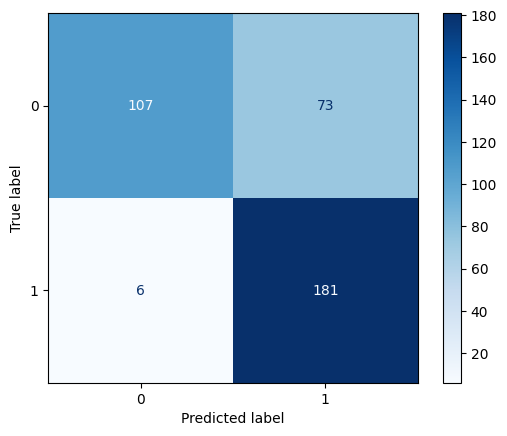

test Loss: 0.56395 | test accuracy: 0.82% | test f1: 0.821
test precision: 0.713 | test recall: 0.968


In [30]:
# device agnostic code
X_test = torch.from_numpy(test_X).type(torch.FloatTensor).to(device)
y_test = torch.from_numpy(test_y).type(torch.FloatTensor).to(device)

# set model into evaluation mode
model.eval()
# turn off gradient tracking for testing
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = f1_score_fn(y_true = y_test, y_pred = test_preds)
    test_precision = precisionm_fn(y_true = y_test, y_pred = test_preds)
    test_recall = recall_fn(y_true = y_test, y_pred = test_preds)
    confusion_matrix_fn(y_true = y_test, y_pred = test_preds)
print(f"test Loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}% | test f1: {test_acc:.3f}")
print(f"test precision: {test_precision:.3f} | test recall: {test_recall:.3f}")